<a href="https://colab.research.google.com/github/neuralabc/PythonTools4Neuroimaging/blob/main/PSYC458_04_rsfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

BOLD rsfMRI can be used to identify the connectivity between pairs of regions/voxels in the brain based on temporally correlated activity. For our purposes, we will use the most symplistic representation of functional connectivity and assess connectivity with the Pearson-product moment correlation `r`.
  - These are _correlations_, and do not form the basis for causal inference (other, more complex, methods attempt to).
  - These are not necessarily _direct_ correlations
    - many interpretations exist
  - These do not contain information about _directionality_ (again, other methods try to address this)

## Preprocessing

1. Follows similar procedures for standard task-based analyses
2. Additional attention should be paid to motion, as this is a significant confound in correlation analyses
  - Shifts in the location of the brain are predictable by the structure of the head/brain, and therefore when motion occurs it will be reflected as temporally correlated changes in BOLD (i.e., "functional correlation")
3. Signal is **band pass** filtered between 0.01 and 0.1 Hz (or 0.01 - 0.08)
  - reduces physiological noise
  - most power in rsfMRI BOLD signal is between 0.01 and 0.05 Hz
4. To reduce the number of correlations computed, BOLD signal is often averaged across regions on interest that are defined based on an atlas {anatomical | functional}
  - This choice that comes with advantages and disadvantages
    - easier and faster
    - assumption of homogeneity of function / BOLD signal in each region
    - potential loss of spatial specificity

In [97]:
# for later, we will use nilearn so we will need to pip install it here
!pip install nilearn

In [98]:
#import the packages that we will be working with
import numpy as np
import matplotlib.pyplot as plt


# Correlations in numpy
As we know, fMRI signal is just changes in BOLD signal over time. This is represented as a vector of numbers, where each subsequent number is the signal value at the next timepoint. Each vector can represent a single voxel/region (i.e., an element) depending on what the input data is.

- We will use `np.corrcoef` to perform correlations
  - performs correlations between one or two `ndarray`s
  - we will need to pay special attention to the required form for the input data to be able to understand the results of this function


In [99]:
#lets see what we will be dealing with
np.corrcoef?

- Pay particular attention to:
```
x : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `x` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same
    shape as `x`.
```

# Correlations between two vectors
- Each vector is simpy a variable (i.e., a voxel) with a series of measurements (in our case, BOLD signal across time)

In [100]:
# lets create some toy data to see how this works
vec1 = np.arange(0,100)
vec2 = np.arange(0,100)*2 
print(np.corrcoef(vec1,vec2))

[[1. 1.]
 [1. 1.]]


Since we provided two vectors, the correlation coefficient is in the upper right corner and lower left corner. The diagonal contains the correlation between each vector and itself.
  - The results are ordered according to the order in which the data was input. (i.e, 1st row/col of output matrix is vec1, 2nd is vec2)
  - Correlation between vec1 and vec2 is therefore at `[0,1]` and `[1,0]`
  - This is a __symmetric__ correlation matrix, since the correlation between vec1 and vec2 is the same as between vec2 and vec1
    - order does not matter 

[[1.         0.99872774]
 [0.99872774 1.        ]]
[[1.         0.88801721]
 [0.88801721 1.        ]]


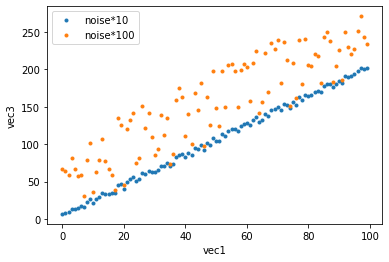

In [101]:
#lets add some random gaussian noise to vec2 so that we can see what the correlation matrix looks like
noise = np.random.rand(100)

#10x the noise vector
vec3 = vec2+noise*10
print(np.corrcoef(vec1,vec3))
plt.plot(vec1,vec3,'.',label='noise*10')

#100x the noise vector
vec3 = vec2+noise*100
print(np.corrcoef(vec1,vec3))
plt.plot(vec1,vec3,'.',label='noise*100')
plt.xlabel('vec1')
plt.ylabel('vec3')

plt.legend()

# Correlations between elements in a matrix
- This is slightly different, as we now define a matrix that contains multiple timeseries (called `variables` in `numpy.corrcoef` help) with multiple `observations` of that variable (i.e., the multiple timepoints in fMRI)

In [102]:
#lets stack the two vectors that we used previously to check if we can get the same output
mat = np.vstack([vec1,vec3]) #stacks rows of data ("vertical" stack)
print(np.corrcoef(mat))

[[1.         0.88801721]
 [0.88801721 1.        ]]


Text(0, 0.5, 'Voxel')

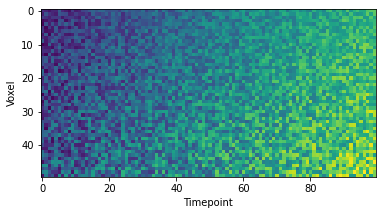

In [103]:
#now lets create some new data, but lets control it so that we know approximately what to expect
#basing everything on vec1, we just modify the noise for subsequent signals

# we want to simulate 50 voxels for correlations
mat = np.zeros((50,100)) #initialize 50 time series of 100 timepoints, all empty

#generate 50 levels of noise (incrementing by one from 50)
noise_multiplier = np.arange(50,100) #vector of noise multiplier

#for each row of the new matrix, we generate some noise and then multiply it by the same position in the 
# multiplier row. This should result in steadily increasing noise as we increment the rows
for row in range(mat.shape[0]):
  _noise = np.random.rand(mat.shape[1]) * noise_multiplier[row]
  mat[row,:] = vec1+_noise

#lets see!
plt.imshow(mat) #values get brigher and more extreme across the rows
plt.xlabel('Timepoint')
plt.ylabel('Voxel')

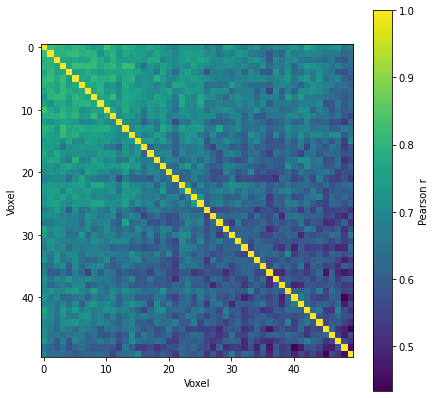

In [104]:
corr_mat = np.corrcoef(mat)
plt.figure(figsize=(7,7))
plt.imshow(corr_mat)
plt.xlabel('Voxel')
plt.ylabel('Voxel')
plt.colorbar(label='Pearson r')

## Correlation Matrix
The figure above is a correlation matrix
- the diagonal (bright yellow set of squares cutting diagonally through the image) is the correlation between every voxel and itself
  - since every signal is exactly the same as itself, it is 1.0 in all cases
  - the off-diagonal values vary, but they _should* look like we would predict from what we did to the data
    - added more noise to later voxels
    - therefore, they should be less correlated than earlier voxels
    - is this what we see?

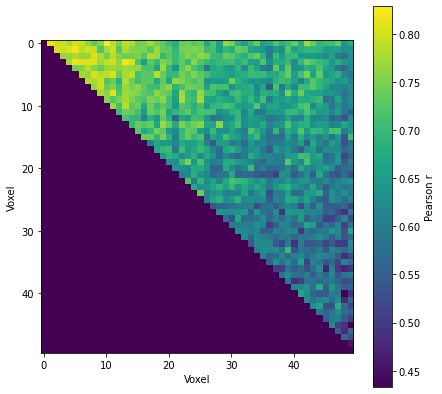

In [105]:
#sometimes it is hard to see variations in correlations in the plot when the diagonal is plotted
# the max of the plot is therefore 1.0, but we don't really care about those values anyway
# we also don't need all of the matrix, since the top and bottom halves are flipped versions of eachother

#can use this code to retain only the upper triangle of the matrix 

upper_lookup = np.triu_indices_from(corr_mat,k=1)
corr_mat_clean = np.zeros_like(corr_mat)
corr_mat_clean[upper_lookup] = corr_mat[upper_lookup]
plt.figure(figsize=(7,7))
plt.imshow(corr_mat_clean,vmin=np.min(corr_mat[upper_lookup])) #we also set the minimum value for display by the colorbar to the minimum non-zero correlation
plt.xlabel('Voxel')
plt.ylabel('Voxel')
plt.colorbar(label='Pearson r')

# Correlations with rsfMRI data
1. Download a segmented atlas
  - ROIs for structurally defined regions (in this case)
2. Downlaod a sample dataset
  - paper describing the work: https://www.sciencedirect.com/science/article/abs/pii/S1053811913003340
  - already preprocessed and band-pass filtered
  - one of the preprocessing steps was to bring this into alignment with the MNI152, which is the same space as the segmented atlas.
    - we only know this by reading the documentation and papers
3. Identify the data and confounds regressors
4. Extract mean data from each voxel and correlate
4. Extract mean data from each voxel, correlate while controlling for regressors of no interest (e.g., head motion)

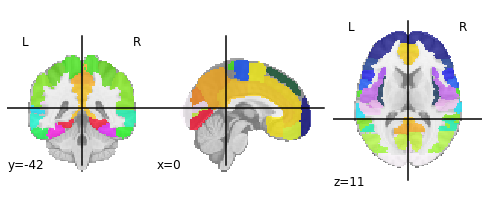

In [106]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
import nibabel as nb

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
# atlas_coords = dataset.coords

plotting.plot_roi(atlas_filename)

In [107]:
print('Atlas ROIs are located in a nifti image (4D) at: %s' %
      atlas_filename)  # 4D atlas data

Atlas ROIs are located in a nifti image (4D) at: <class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qfo

In [108]:
# download a single subject's data from https://www.sciencedirect.com/science/article/abs/pii/S1053811913003340
data = datasets.fetch_development_fmri(n_subjects=1)
fmri_filenames = data.func[0]

#what is in this dataset
print(data.keys())
print(fmri_filenames)
print("time series shape: {}".format(nb.load(fmri_filenames).shape))

dict_keys(['func', 'confounds', 'phenotypic', 'description'])
/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
time series shape: (50, 59, 50, 168)


## Perform correlations between all pairs of ROIs

In [109]:
# create a "nifti masker" to do the hard work of computing the mean signal in each atlas label over time
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

In [110]:
# the masker will extract the timeseries from the nifti file(s) and return it to us in an array
# that we can use for further processing
time_series_raw = masker.fit_transform(fmri_filenames)
time_series = masker.fit_transform(fmri_filenames, confounds=data.confounds)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]0.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]0.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [111]:
# this atlas has 48 regions, so we end up with an extracted 
#timeseries of 168 volumes and 48 regions
print(time_series_raw.shape)

(168, 48)


(48, 168)


(<matplotlib.image.AxesImage at 0x7ffb49d3bad0>,
 <matplotlib.colorbar.Colorbar at 0x7ffb49cfad50>)

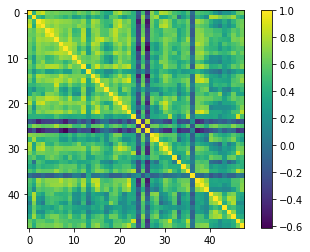

In [112]:
#we can correlate this data to find our connectivity matrix, which is as simple as
# 1. flipping the data (transposing it) so that it is in the form required by np.corrcoef
#    - this is done by appending ".T" to the end of the matrix
#     - then we will have 48*168 as expected by np.corrcoef
# 2. running the correlation
# 3. plotting the data

print(time_series_raw.T.shape)
raw_fMRI_corr_mat = np.corrcoef(time_series_raw.T)
plt.imshow(raw_fMRI_corr_mat),plt.colorbar()



Text(0.5, 1.0, 'Correlation matrix (confounds removed)')

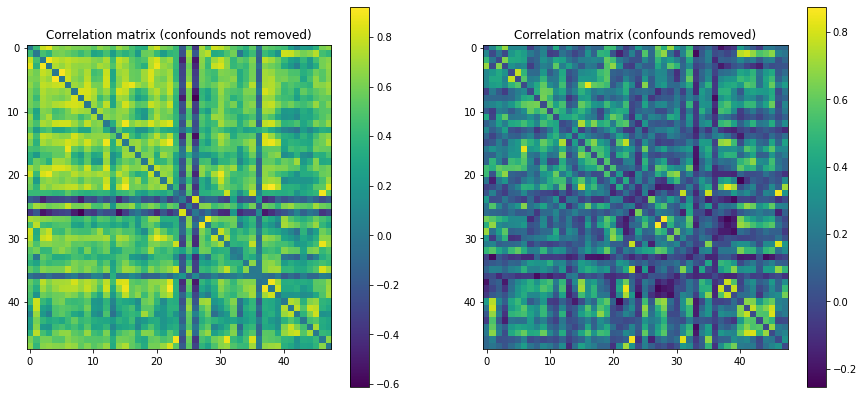

In [113]:
# lets do the same thing, but put the raw correlation up against one computed after removing confounds
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
raw_fMRI_corr_mat = np.corrcoef(time_series_raw.T)
np.fill_diagonal(raw_fMRI_corr_mat,0) #here we fill the diagonal with 0s so that we don't see self-correlations
plt.imshow(raw_fMRI_corr_mat),plt.colorbar()
plt.title('Correlation matrix (confounds not removed)')

plt.subplot(1,2,2)
fMRI_corr_mat = np.corrcoef(time_series.T)
np.fill_diagonal(fMRI_corr_mat,0)
plt.imshow(fMRI_corr_mat),plt.colorbar()
plt.title('Correlation matrix (confounds removed)')

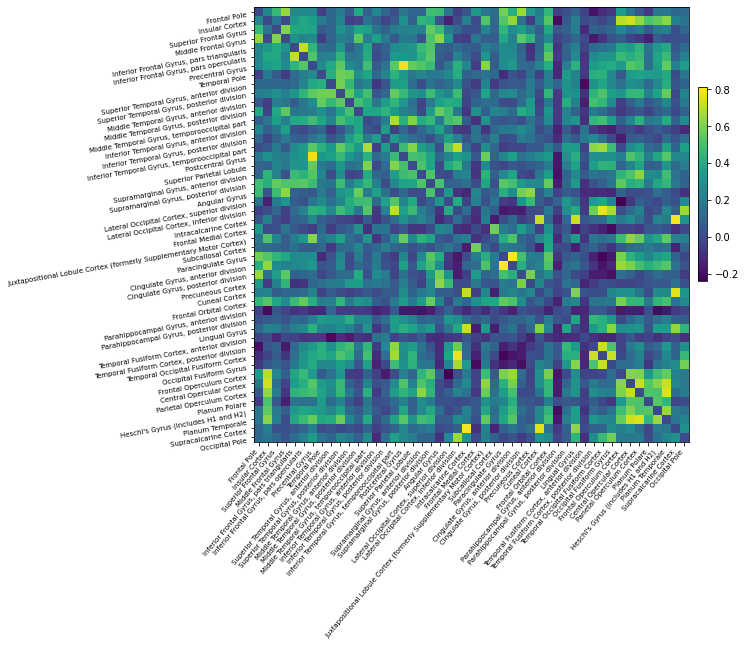

In [114]:
#nilearn also has its own functions for computing (called "fitting") and plotting correlation matrices
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation if reorder=True
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:], 
                     cmap='viridis', reorder=False)

## Perform correlation between single ROI and all voxels
This can also be referred to as a _seed-based correlation_.
1. Identify the labels from above and choose an ROI to use as the seed location
  - alternatively, you could use a single voxel as a seed
2. Extract the timeseries (either average of ROI, or from seed voxel)
3. Correlate timeseries with all voxels
4. Results in a single 3D map of correlation values at every location in the original functional image

** --- this is not complete below --- **


In [115]:
#lets choose an ROI, first we check the labels from our atlas
labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

In [116]:
# I am interested in this region so I will select it by finding its index 
# chosen_ROI = 'Precentral Gyrus'
# chosen_ROI = 'Angular Gyrus'
# chosen_ROI = "Heschl's Gyrus (includes H1 and H2)"
chosen_ROI = 'Planum Temporale'
chosen_ROI =  'Cingulate Gyrus, anterior division'
# I will just loop pver the lablels and find a match, then return the index to it
for idx, label in enumerate(labels):
  if label == chosen_ROI:
    print(f"Found you at index: {idx}")
    idx_ROI = idx

Found you at index: 29


In [117]:
#we pull that the mean data from that ROI based on the index location
#referencing the data that we already processed
ts_ROI = time_series[:,idx_ROI]

#we need to clean all voxels of the input data, so we need a different function
from nilearn.image.image import clean_img
#here we use a different function to remove confounds in this image because we want to keep all voxels
# the previous command took the mean across all voxels in a single ROI defined by the atlas
vox_ts_clean = clean_img(fmri_filenames,confounds=data.confounds) 

In [118]:
#we need to change this 4d data into a 2d matrix that we can work with in np.corrcoef
#first we see what its shape is
img_shape = vox_ts_clean.shape
print(img_shape)
#now we know the number of voxels (multiplication of first three dimensions xyz) and the number of volumes
n_vox = img_shape[0]*img_shape[1]*img_shape[2]
n_vol = img_shape[3]

(50, 59, 50, 168)


In [119]:
#we can use numpy to reshape the data the way that we want it
# BUT, we should check to make sure that these are really the timeseries that we expected!
#and wait a second, we include non-brain values in this too... 
vox_ts_mat = vox_ts_clean.get_fdata().reshape(n_vox,n_vol)
print(vox_ts_mat.shape)

(147500, 168)


In [120]:
#an alternative is to define a mask, then extract from that mask like we did before
#we take the first volume of data, and create a boolean mask where greater than 0
d_mask = vox_ts_clean.get_fdata()[...,0] >0
print(d_mask.shape) #should be the shape of a single volume of data!

#now we can extract the timesries from our 3d boolean mask
vox_ts_mat_v2 = vox_ts_clean.get_fdata()[d_mask,:] #now I am explicitly pulling from only the mask locations 
print(vox_ts_mat_v2.shape) #this matrix is CONSIDERABLY smaller than the previous
#and fewer voxels means less memory taken by our processing

(50, 59, 50)
(14907, 168)


In [121]:
#now lets compute the correlation between our seed and our data
# we want to correlate the ts_ROI with the ts of every voxel
# first we define a vector to store the results
vox_corr_vec = np.zeros(vox_ts_mat_v2.shape[0])

#then we can loop over each voxel and compute the correlation
for idx in range(vox_corr_vec.shape[0]):
  r_val = np.corrcoef(ts_ROI,vox_ts_mat_v2[idx,:])[0,1] #we know that the diagonal will contain self-correlation, so we select the off-diag
  vox_corr_vec[idx] = r_val 

In [122]:
#now we need to push our vector back into the 3d space of the brain.
#create an empty 3d dataset of the correct size
d_out = np.zeros(d_mask.shape)
#now push the data into the correct voxel locations based on the mask that we created and extracted the ts values with!
d_out[d_mask] = vox_corr_vec

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



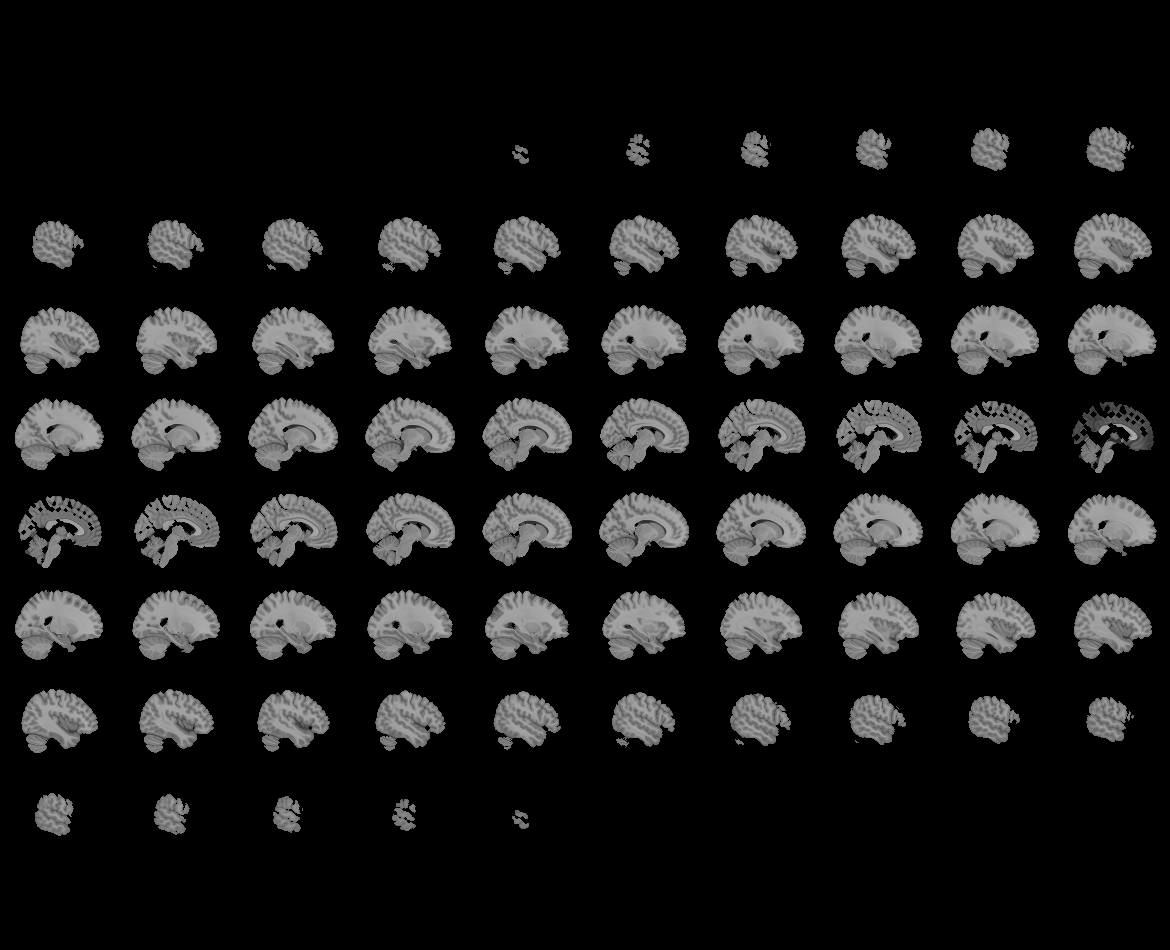
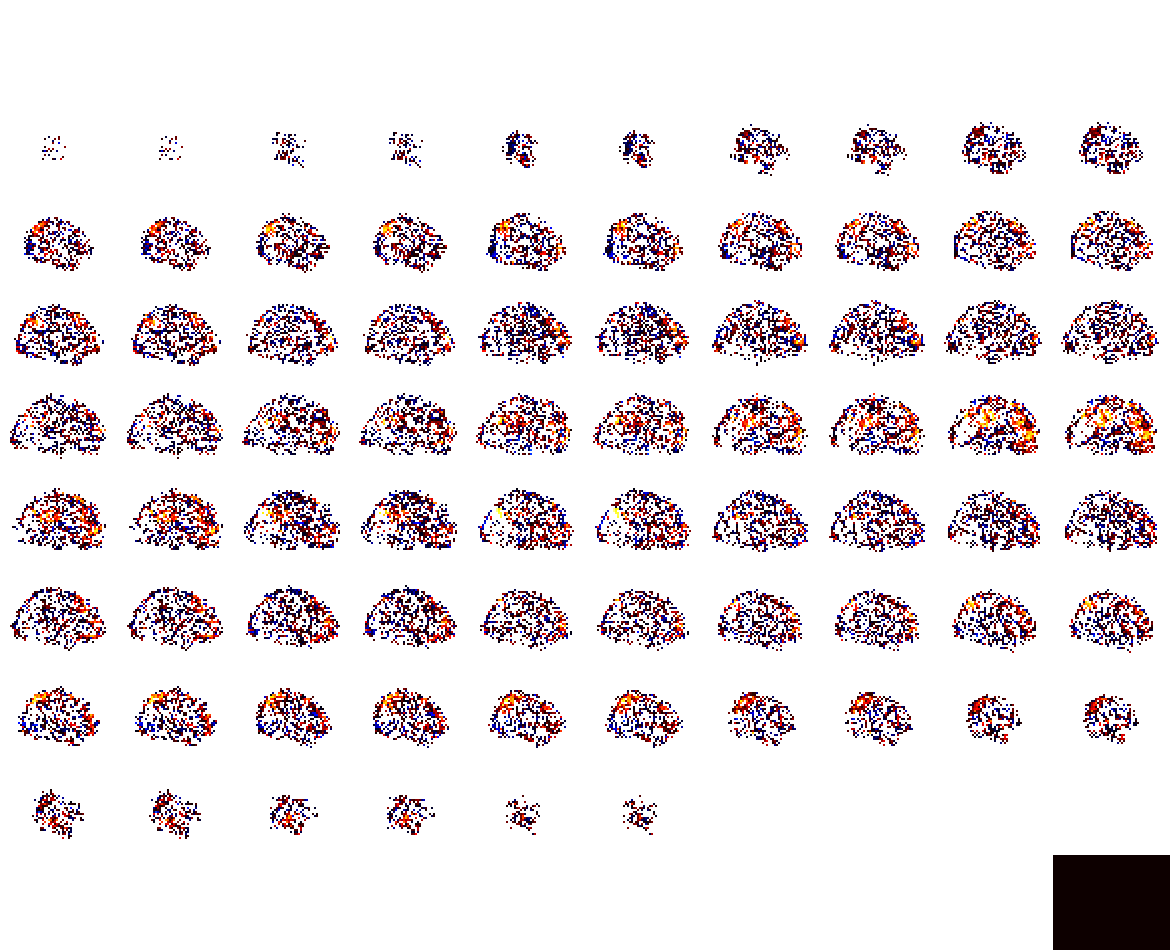

In [123]:
#to display, we can make this into a .nii.gz image
img_out = nb.Nifti1Image(d_out,affine=vox_ts_clean.affine,header=vox_ts_clean.header)
img_out.update_header()
plotting.view_img(img_out,resampling_interpolation='nearest',opacity=.75)

In [125]:
plotting.view_img_on_surf(img_out,threshold='90%')

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))
